# Training Resnet Architecture

## Google Drive Settings

In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/icdss')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# Load the TensorBoard notebook extension.
%load_ext tensorboard

TensorFlow 2.x selected.


## Data Preprocessing

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from reader import get_images
from tensorflow.keras import utils
from sklearn.model_selection import train_test_split

In [4]:
(x_train, y_train_raw), (x_test, y_test_raw) = get_images() 

# Reshape data to image's dimension 28 by 28
x_train = x_train.reshape(-1,28,28)
x_test = x_test.reshape(-1,28,28)

#add another dimension to the data
x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)
x_train.shape , x_test.shape

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)


/content/drive/My Drive/Colab Notebooks/icdss/reader.py:38: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  x_train = df_train.drop('label', axis=1).as_matrix().astype(np.uint8)
/content/drive/My Drive/Colab Notebooks/icdss/reader.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  y_train = df_train['label'].as_matrix().astype(np.uint8)
/content/drive/My Drive/Colab Notebooks/icdss/reader.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  x_test = df_test.drop('label', axis=1).as_matrix().astype(np.uint8)
/content/drive/My Drive/Colab Notebooks/icdss/reader.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  y_test = df_test['label'].as_matrix().astype(np.uint8)


In [5]:
#Change classes to a categorical type
num_classes = 10
y_train = utils.to_categorical(y_train_raw, num_classes)
y_test = utils.to_categorical(y_test_raw, num_classes)

# split original training data to 80 % training data and the other 20% for validation data
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=13)

# Check the data size
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((48000, 28, 28, 1), (12000, 28, 28, 1), (48000, 10), (12000, 10))

In [ ]:
# Random Erasing Data Augmentation
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [ ]:
eraser = get_random_eraser()
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(8, 8)

for i, img in enumerate(x_train[:16]):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(4, 4, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    
    plt.imshow(eraser(img/255))

plt.show()

In [7]:
# All images will be rescaled by 1./255. We apply data augmentation here.
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,
                                   width_shift_range=0.1,  
                                   height_shift_range=0.1, 
                                   fill_mode='nearest',
                                   preprocessing_function=get_random_eraser(v_l=0, v_h=1))

val_datagen = ImageDataGenerator(rescale=1./255,  
                                  fill_mode='nearest')

# Batch size
bs = 32
# Flow training images in batches of 32 using train_datagen generator
print("Preparing generator for train dataset")
train_generator = train_datagen.flow(x_train, 
                                     y_train, 
                                     batch_size=bs)

# Flow validation images in batches of 32 using val_datagen generator
print("Preparing generator for validation dataset")
val_generator = val_datagen.flow(x_val, 
                                 y_val,
                                 batch_size=bs)

Preparing generator for train dataset
Preparing generator for validation dataset


## Building Model

In [ ]:
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation, add
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, Input, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

In [ ]:
#Defining parameters
num_classes = 10
num_filters = 64
num_blocks = 4
num_sub_blocks = 2
use_max_pool = False

In [9]:
#Creating model based on ResNet published archietecture
inputs = Input(shape=(28,28,1))
x = Conv2D(num_filters, padding='same', 
           kernel_initializer='he_normal', 
           kernel_size=7, strides=2,
           kernel_regularizer=l2(1e-4))(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)

#Check by applying max pooling later (setting it false as size of image is small i.e. 28x28)
if use_max_pool:
    x = MaxPooling2D(pool_size=3,padding='same', strides=2)(x)
    num_blocks =3
#Creating Conv base stack 

# Instantiate convolutional base (stack of blocks).
for i in range(num_blocks):
    for j in range(num_sub_blocks):
        strides = 1
        is_first_layer_but_not_first_block = j == 0 and i > 0
        if is_first_layer_but_not_first_block:
            strides = 2
        #Creating residual mapping using y
        y = Conv2D(num_filters,
                   kernel_size=3,
                   padding='same',
                   strides=strides,
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4))(x)
        y = BatchNormalization()(y)
        y = Activation('relu')(y)
        y = Conv2D(num_filters,
                   kernel_size=3,
                   padding='same',
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4))(y)
        y = BatchNormalization()(y)
        if is_first_layer_but_not_first_block:
            x = Conv2D(num_filters,
                       kernel_size=1,
                       padding='same',
                       strides=2,
                       kernel_initializer='he_normal',
                       kernel_regularizer=l2(1e-4))(x)
        #Adding back residual mapping
        x = add([x, y])
        x = Activation('relu')(x)

    num_filters = 2 * num_filters

# Add classifier on top.
x = AveragePooling2D()(x)
y = Flatten()(x)
outputs = Dense(num_classes,
                activation='softmax',
                kernel_initializer='he_normal')(y)

# Instantiate and compile model.
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   3200        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 14, 14, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 14, 14, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Training Model

In [ ]:
# Prepare callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.5e-6)
bestValidationCheckpointer = ModelCheckpoint('train_model_resnet.hdf5', monitor='val_loss', save_best_only=True, verbose=1)

In [ ]:
data_augmentation = False

In [17]:
if data_augmentation:
    history = model.fit_generator(train_generator,
                                  epochs=10,
                                  validation_data=val_generator, 
                                  callbacks=[bestValidationCheckpointer,reduce_lr],
                                  verbose = 1)
else:
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=10,
                        validation_data=(x_val, y_val),
                        shuffle=True,
                        callbacks=[bestValidationCheckpointer,reduce_lr])

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
47900/48000 [============================>.] - ETA: 0s - loss: 0.3498 - accuracy: 0.9332
Epoch 00001: val_loss did not improve from 0.41304
48000/48000 [==============================] - 52s 1ms/sample - loss: 0.3498 - accuracy: 0.9333 - val_loss: 0.4666 - val_accuracy: 0.8965
Epoch 2/10
47900/48000 [============================>.] - ETA: 0s - loss: 0.3352 - accuracy: 0.9362
Epoch 00002: val_loss did not improve from 0.41304
48000/48000 [==============================] - 52s 1ms/sample - loss: 0.3352 - accuracy: 0.9362 - val_loss: 0.4282 - val_accuracy: 0.9082
Epoch 3/10
47900/48000 [============================>.] - ETA: 0s - loss: 0.3224 - accuracy: 0.9418
Epoch 00003: val_loss did not improve from 0.41304
48000/48000 [==============================] - 52s 1ms/sample - loss: 0.3224 - accuracy: 0.9418 - val_loss: 0.4498 - val_accuracy: 0.8995
Epoch 4/10
47900/48000 [============================>.] - ETA: 0s - loss: 0.3136 - 

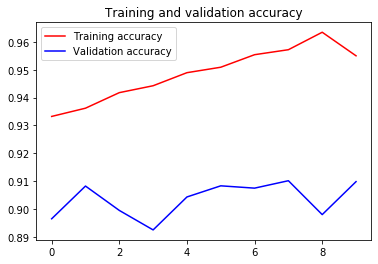

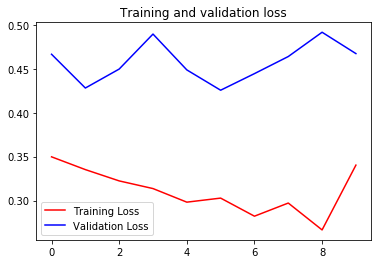

In [20]:
# Plot the chart for accuracy and loss on both training and validation

import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [21]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================